In [1]:
import os
import pandas as pd

def get_cluster_data(data_dir):

    cluster_data = pd.DataFrame()

    for cohort_folder in os.listdir(data_dir):
        if cohort_folder.startswith('IBD'):
            cohort_path = os.path.join(data_dir, cohort_folder)
            
            crc_df = pd.read_csv(os.path.join(cohort_path, 'se_IBD.tsv'), sep='\t')
            crc_df['cohort'] = cohort_folder
            crc_df['label'] = 1
            crc_df = crc_df.rename(columns={'Unnamed: 0': 'sample'})

            health_df = pd.read_csv(os.path.join(cohort_path, 'se_Health.tsv'), sep='\t')
            health_df['cohort'] = cohort_folder
            health_df['label'] = 0
            health_df = health_df.rename(columns={'Unnamed: 0': 'sample'})
            
            cohort_data = pd.concat([crc_df, health_df], ignore_index=True)

            cluster_data = pd.concat([cluster_data, cohort_data], ignore_index=True)
    
    return cluster_data

cluster_df = get_cluster_data('../result/GCN_fix_tree/SE/GCN_tree_diff/IBD')

print(cluster_df.columns)

Index(['sample', 'cluster_S1-C1', 'cluster_S1-C2', 'cluster_S1-C3',
       'cluster_S1-C4', 'cluster_S1-C5', 'cluster_S1-C6', 'cluster_S1-C7',
       'cluster_S1-C8', 'cluster_S1-C9', 'cluster_S1-C10', 'cluster_S1-C11',
       'cluster_S1-C12', 'cluster_S1-C13', 'cluster_S1-C14', 'cluster_S1-C15',
       'cluster_S1-C16', 'cluster_S1-C17', 'cluster_S1-C18', 'cluster_S1-C19',
       'cluster_S1-C20', 'cluster_S1-C21', 'cluster_S1-C22', 'cluster_S1-C23',
       'cluster_S1-C24', 'cluster_S1-C25', 'cluster_S1-C26', 'cluster_S1-C27',
       'cluster_S1-C28', 'cluster_S2-C1', 'cluster_S2-C2', 'cluster_S2-C3',
       'cluster_S2-C4', 'cluster_S2-C5', 'cluster_S2-C6', 'cluster_S2-C7',
       'cluster_S2-C8', 'cluster_S3-C1', 'cluster_S3-C2', 'cluster_S3-C3',
       'cluster_S3-C4', 'cluster_S3-C5', 'cluster_S4-C1', 'cluster_S4-C2',
       'cluster_S4-C3', 'cluster_S4-C4', 'cluster_S5-C1', 'cluster_S5-C2',
       'cluster_S5-C3', 'cluster_S5-C4', 'cluster_S6-C1', 'cluster_S6-C2',
       'clust

In [2]:
import os
import numpy as np
import pandas as pd
from itertools import chain

data_dir = '../result/GCN_fix_tree/SE/GCN_tree_diff/IBD'
outdir = '../result/predict'
if not os.path.exists(outdir):
    os.makedirs(outdir)
p_files = [os.path.join(data_dir, cohort, f'p_{cohort}.tsv') for cohort in os.listdir(data_dir)]

all_significant = []
for p_file in p_files:
    p_df = pd.read_csv(p_file, sep='\t')
    significant_clusters = p_df[p_df['p_adj'] < 0.05]['Unnamed: 0'].tolist()
    all_significant.append(significant_clusters)

significant_clusters = []
for cluster in set(chain(*all_significant)):
    if sum(cluster in s for s in all_significant) >= 2:
        significant_clusters.append(cluster)

print(f"Significant clusters: {significant_clusters}")

Significant clusters: ['cluster_S1-C4', 'cluster_S6-C1', 'supercluster_S6', 'root', 'cluster_S1-C20', 'cluster_S1-C15', 'cluster_S2-C5', 'supercluster_S2', 'cluster_S1-C22', 'cluster_S1-C17', 'cluster_S1-C10', 'cluster_S1-C9', 'cluster_S1-C5', 'cluster_S6-C3', 'cluster_S1-C16', 'cluster_S1-C1', 'supercluster_S3', 'cluster_S2-C4', 'cluster_S1-C3']


In [3]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

selected_columns = significant_clusters + ['sample', 'cohort', 'label']
selected_df = cluster_df[selected_columns]

feature_importance_sum = {feature: 0 for feature in significant_clusters}

validation_auc_results = []

for exclude_cohort in [f'IBD{i}' for i in range(1, 4)]:
    print(f"Excluding cohort: {exclude_cohort}")
    
    train_df = selected_df[selected_df['cohort'] != exclude_cohort]
    val_df = selected_df[selected_df['cohort'] == exclude_cohort]
    
    print("Training data shape:", train_df.shape)
    print("Validation data shape:", val_df.shape)
    

    X_train = train_df[significant_clusters]
    y_train = train_df['label']

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred)
    print(f"Training AUC: {train_auc:.2f}")
    
    X_val = val_df[significant_clusters]
    y_val = val_df['label']
    y_pred = rf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred)
    print(f"Validation AUC: {val_auc:.2f}")
    
    for feature, importance in zip(significant_clusters, rf.feature_importances_):
        feature_importance_sum[feature] += importance
    
    validation_auc_results.append(val_auc)
    
    print()

print("Feature Importance Sum:")
for feature, importance_sum in sorted(feature_importance_sum.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance_sum:.4f}")

print(f"Validation AUC: {np.mean(validation_auc_results):.2f} +/- {np.std(validation_auc_results):.2f}")

Excluding cohort: IBD1
Training data shape: (1121, 22)
Validation data shape: (393, 22)
Training AUC: 1.00
Validation AUC: 0.69

Excluding cohort: IBD2
Training data shape: (1255, 22)
Validation data shape: (259, 22)
Training AUC: 1.00
Validation AUC: 0.66

Excluding cohort: IBD3
Training data shape: (652, 22)
Validation data shape: (862, 22)
Training AUC: 1.00
Validation AUC: 0.76

Feature Importance Sum:
cluster_S1-C15: 0.3735
cluster_S1-C3: 0.2962
cluster_S1-C1: 0.2560
cluster_S1-C20: 0.2312
root: 0.2174
cluster_S1-C5: 0.1744
cluster_S1-C10: 0.1688
cluster_S1-C16: 0.1623
supercluster_S2: 0.1606
supercluster_S6: 0.1578
cluster_S1-C9: 0.1484
cluster_S2-C5: 0.1227
cluster_S6-C1: 0.1220
supercluster_S3: 0.1139
cluster_S6-C3: 0.0774
cluster_S1-C4: 0.0656
cluster_S1-C17: 0.0626
cluster_S1-C22: 0.0465
cluster_S2-C4: 0.0428
Validation AUC: 0.71 +/- 0.04


In [4]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from sklearn.model_selection import StratifiedKFold

def run_cv_on_cohort(data_dir, disease, cohort):

    p_file = os.path.join(data_dir, disease, cohort, f'p_{cohort}.tsv')
    p_df = pd.read_csv(p_file, sep='\t')
    significant_clusters = p_df.loc[p_df['p_adj'] < 0.05, 'Unnamed: 0'].tolist()
    
    cluster_data = pd.DataFrame()
    for file_name in os.listdir(os.path.join(data_dir, disease, cohort)):
        if file_name.startswith(f'se_') and file_name.endswith('.tsv'):
            file_path = os.path.join(data_dir, disease, cohort, file_name)
            df = pd.read_csv(file_path, sep='\t')
            if file_name == f'se_Health.tsv':
                df['label'] = 0
            else:
                df['label'] = 1
            df = df.rename(columns={'Unnamed: 0': 'sample', 'cohort': 'cohort'})
            
            cluster_data = pd.concat([cluster_data, df], ignore_index=True)
    
    cohort_df = cluster_data
    
    auc_results = []
    mean_fpr = np.linspace(0, 1, 20)
    mean_tpr = np.zeros((20,))
    
    feature_importance_sum = {feature: 0 for feature in significant_clusters}

    for _ in range(20):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        fold_auc_results = []
        fold_tprs = []
        for train_index, val_index in skf.split(cohort_df[significant_clusters], cohort_df['label']):
            train_df = cohort_df.iloc[train_index]
            val_df = cohort_df.iloc[val_index]
       
            X_train = train_df[significant_clusters]
            y_train = train_df['label']

            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)

            X_val = val_df[significant_clusters]
            y_val = val_df['label']
            y_pred = rf.predict(X_val)
            val_auc = roc_auc_score(y_val, y_pred)
            fold_auc_results.append(val_auc)

            fpr, tpr, _ = roc_curve(y_val, y_pred)
            fold_tprs.append(np.interp(mean_fpr, fpr, tpr))
            fold_tprs[-1][0] = 0.0

            for feature, importance in zip(significant_clusters, rf.feature_importances_):
                feature_importance_sum[feature] += importance
        
        auc_results.append(np.mean(fold_auc_results))
    
    mean_auc = np.mean(auc_results)
    auc_std = np.std(auc_results)
    auc_95ci = (mean_auc - 1.96 * auc_std, mean_auc + 1.96 * auc_std)
    
    auc_95ci = (round(auc_95ci[0], 2), round(auc_95ci[1], 2))

    for fold_tpr in fold_tprs:
        mean_tpr += fold_tpr
    mean_tpr /= len(fold_tprs)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0

    mean_feature_importance = {feature: importance / 200 for feature, importance in feature_importance_sum.items()}

    return significant_clusters, round(mean_auc, 2), auc_95ci, mean_fpr, mean_tpr, mean_feature_importance

IBD1,0.78(0.76~0.8)


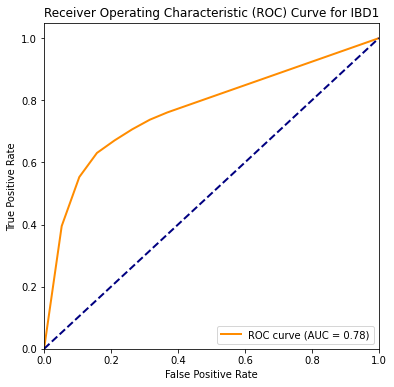

[('cluster_S1-C1', 0.12317952291029466), ('cluster_S2-C5', 0.10323995291761305), ('supercluster_S2', 0.09460319357233399), ('cluster_S1-C20', 0.06916008939754448), ('cluster_S1-C16', 0.05630046165159645), ('cluster_S1-C4', 0.05362019581178416), ('cluster_S1-C9', 0.049951207819171645), ('cluster_S1-C15', 0.04701485966528212), ('cluster_S6-C1', 0.04530472872146867), ('root', 0.0452643560692761), ('cluster_S1-C10', 0.04204285179567955), ('cluster_S1-C22', 0.0412036229043569), ('cluster_S1-C5', 0.040813829120651436), ('cluster_S1-C3', 0.038440058195608896), ('supercluster_S6', 0.03661228710381731), ('cluster_S1-C24', 0.029023944825380912), ('cluster_S1-C17', 0.02734998590489086), ('supercluster_S3', 0.02709085402092888), ('cluster_S2-C4', 0.016574915394765712), ('cluster_S1-C13', 0.013209082197554114)]


In [5]:
# IBD1
data_dir = '../result/GCN_fix_tree/SE/GCN_tree_diff'
disease = 'IBD'
cohort = 'IBD1'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, disease, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# 绘制ROC曲线
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)

IBD2,0.85(0.83~0.87)


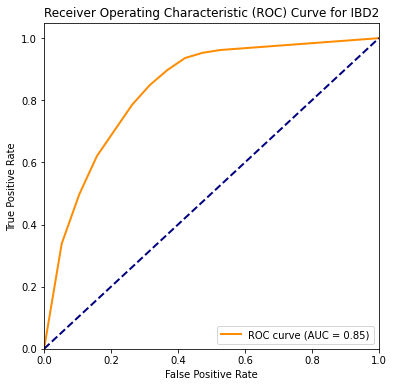

[('cluster_S1-C3', 0.15815985724614184), ('cluster_S1-C15', 0.14481193760227698), ('cluster_S1-C9', 0.12488299460566392), ('cluster_S1-C1', 0.08926541621361268), ('cluster_S1-C5', 0.08891945142603142), ('supercluster_S6', 0.0861747461034297), ('cluster_S1-C17', 0.07500249909200454), ('cluster_S1-C16', 0.049770372160125545), ('supercluster_S2', 0.04897320829359409), ('cluster_S6-C1', 0.03840595478714749), ('cluster_S1-C4', 0.02816468703340589), ('supercluster_S5', 0.02579678892833902), ('cluster_S6-C3', 0.017329813619074694), ('cluster_S2-C4', 0.013312813942121407), ('cluster_S5-C2', 0.007892731667326512), ('cluster_S1-C22', 0.003136727279704302)]


In [6]:
# IBD2
data_dir = '../result/GCN_fix_tree/SE/GCN_tree_diff'
disease = 'IBD'
cohort = 'IBD2'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, disease, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# 绘制ROC曲线
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)

IBD3,0.83(0.82~0.84)


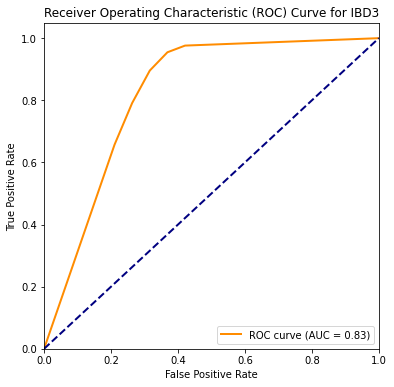

[('cluster_S1-C15', 0.13644523529307995), ('supercluster_S1', 0.09898963463785487), ('cluster_S1-C3', 0.09607087411696807), ('cluster_S1-C8', 0.07847895924108932), ('cluster_S1-C10', 0.07747830665472069), ('cluster_S1-C16', 0.07630288488950276), ('cluster_S1-C20', 0.07513343983595246), ('root', 0.0716923972007292), ('cluster_S1-C2', 0.07044367475383877), ('cluster_S1-C1', 0.06900281167313112), ('supercluster_S3', 0.06039864143936342), ('cluster_S6-C3', 0.0431118789893448), ('cluster_S2-C5', 0.037858569019073036), ('cluster_S3-C1', 0.008592692255351593)]


In [7]:
# IBD3
data_dir = '../result/GCN_fix_tree/SE/GCN_tree_diff'
disease = 'IBD'
cohort = 'IBD3'

significant_clusters, mean_auc, auc_95ci, mean_fpr, mean_tpr,mean_feature_importance = run_cv_on_cohort(data_dir, disease, cohort)
print(f"{cohort},{mean_auc}({auc_95ci[0]}~{auc_95ci[1]})")

# 绘制ROC曲线
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {cohort}')
plt.legend(loc="lower right")

plt.savefig(os.path.join(outdir, '{}.self.roc_curve.svg'.format(cohort)), format='svg')
plt.show()

sorted_feature_importance = sorted(mean_feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_feature_importance)